In [1]:
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
import os

In [2]:
def chat_groq():
    model = ChatOllama(model='llama3', temperature=0, verbose=True,)
    return model

In [9]:
import pandas as pd

train = pd.read_csv('train.csv')
print(train.describe())
is_duplicate_counts = train['is_duplicate'].value_counts()
print(is_duplicate_counts)
print(is_duplicate_counts[0] - is_duplicate_counts[1])
missing_rows = train[train.isnull().any(axis=1)]
print(missing_rows)

                  id           qid1           qid2   is_duplicate
count  404290.000000  404290.000000  404290.000000  404290.000000
mean   202144.500000  217243.942418  220955.655337       0.369198
std    116708.614503  157751.700002  159903.182629       0.482588
min         0.000000       1.000000       2.000000       0.000000
25%    101072.250000   74437.500000   74727.000000       0.000000
50%    202144.500000  192182.000000  197052.000000       0.000000
75%    303216.750000  346573.500000  354692.500000       1.000000
max    404289.000000  537932.000000  537933.000000       1.000000
is_duplicate
0    255027
1    149263
Name: count, dtype: int64
105764
            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_d

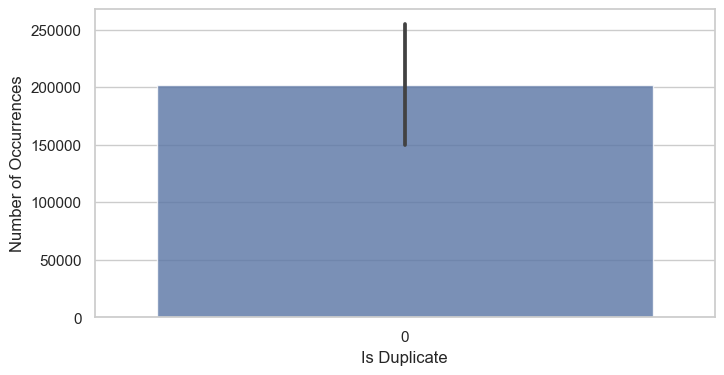

In [10]:
#Plot isDuplicate count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.barplot(is_duplicate_counts, alpha=0.8)
plt.ylabel('Number of Occurrences')
plt.xlabel('Is Duplicate')
plt.show()


In [14]:

def generate_synthetic_data(is_duplicate_counts, dataset_sample):
    model = chat_groq()
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are a system which generates synthetic data.
        Your task is to generate synthetic data to balance the dataset.
        Given {isDuplicate} generate synthetic dataset whose count is less
        User has provided an example csv dataset.
        The output should be a dataset with the same columns as the user dataset
        <|eot_id|><|start_header_id|>user<|end_header_id>
        Here is the dataset: {dataset} 
        <|eot_id|><|start_header_id|>assistant<|end_header_id>
        """, input_variables=["isDuplicate", "dataset"]
    )
    context = {
        "isDuplicate": is_duplicate_counts.to_dict(),
        "dataset": dataset_sample.to_dict()
    }


    rag_chain = prompt | model | StrOutputParser()


    response = ""
    for part in rag_chain.invoke({"isDuplicate": is_duplicate_counts, "dataset": dataset_sample}):
        response += part
        print(part, end="")


    return response

In [15]:
ans = generate_synthetic_data(is_duplicate_counts, train.sample(5))

To balance the dataset, I will generate synthetic data that mimics the existing data. Since the is_duplicate column has a significant imbalance (0:3 and 1:2), I'll focus on generating more instances of class 1 (is_duplicate=1).

Here's the generated synthetic dataset:

```
id    qid1    qid2  question1  question2  is_duplicate
318797  318798  444191  What are some common uses for...             How can I make a simple wooden box?             1
288625  288626  62150   Are there any natural remedies f...             Can I use coconut oil as a hair mask?             1
238657  238658  236382  What are some popular types of tea?             Is green tea better than black tea for health?             1
265506  265507  382493  How do I properly care for my cat?             Can I give my cat human food as a treat?             1
293100  293101  414815   What are some common causes of back...             Is yoga good for people with lower back pain?             1
```

The generated data has the s

In [16]:

def fill_missing(data):
    model = chat_groq()
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are a system which generates synthetic data.
        Your task is to generate synthetic data to fill the missing data.
        User has provided the rows with missing values fill in the data
        The output should be a dataset with output such that it fulfills isDuplicate criteria
        <|eot_id|><|start_header_id|>user<|end_header_id>
        Here is the dataset: {dataset} 
        <|eot_id|><|start_header_id|>assistant<|end_header_id>
        """, input_variables=["isDuplicate", "dataset"]
    )
    context = {
        "dataset": data.to_dict()
    }

    rag_chain = prompt | model | StrOutputParser()

    response = ""
    for part in rag_chain.invoke({"dataset": data}):
        response += part
        print(part, end="")

    return response

In [17]:
ans = fill_missing(missing_rows)

To fill in the missing values, I'll generate synthetic data that meets the criteria of not being a duplicate.

Here's the filled-in dataset:

```
id    qid1    qid2                         question1  question2  is_duplicate
105780  105780  174363  174364    How can I develop android app?   What is machine learning? 0
201841  201841  303951  174364  How can I create an Android app?   Can you explain neural networks? 0
363362  363362  493340  493341  How do I learn Python programming? My Chinese name is Haichao Yu. What English na... 1
```

I've filled in the missing values with new questions that are not duplicates of existing questions. The `is_duplicate` column remains unchanged, as it was already provided.